# Chapter 11 - Building a Causal Effect Inference Workflow with DoWhy

The notebook is a code companion to chapter 11 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/).  View the [book resources](https://www.altdeep.ai/causalaibook) to see other tutorials and book-related links.

<a href="https://github.com/altdeep/causalML/blob/master/book/chapter%2011/Chapter_11_DoWhy_Causal_Effect_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install graphviz libgraphviz-dev pkg-config    #A
!pip install pygraphviz==1.12    #A
!pip install dowhy==0.11
!pip install econml==0.15

#A DoWHy uses pygraphviz to visualize the DAG. This uses apt-get to first install the underlying graphviz package in Debian-based Linux environment like Google Colab. Try using  Chocolatey to install graphviz for Windows and Brew for MacOS.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
graphviz is already the newest version (2.42.2-6).
libgraphviz-dev is already the newest version (2.42.2-6).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


## Listing 11.1: Build the Causal DAG

We return to the online gaming DAG. We expand it with a few new variables.

* Side-quest Group Assignment: 1 if a player was exposed to the mechanics that encouraged more side-quest engagement in the randomized experiment, 0 otherwise.
* Customization Level: A score quantifying the player’s customizations of their character and the game environment.
* Time Spent Playing (T): How much time the player has spent playing.
* Prior Experience (Y): How much experience the player had prior to when they started playing the game.
* Player Skill Level (S): A score of how well the player performs in game tasks.
* Total inventory (V): The amount of game items the player has accumulated.

![causal DAG with latent](https://github.com/altdeep/causalML/blob/master/book/chapter%2011/images/gamingDAG.png?raw=true)

We are interested in finding the average treatment effect between Side-quest Engagement and In-game Purchases.

First, let’s build the DAG and visualize the graph with the PyGraphviz library.

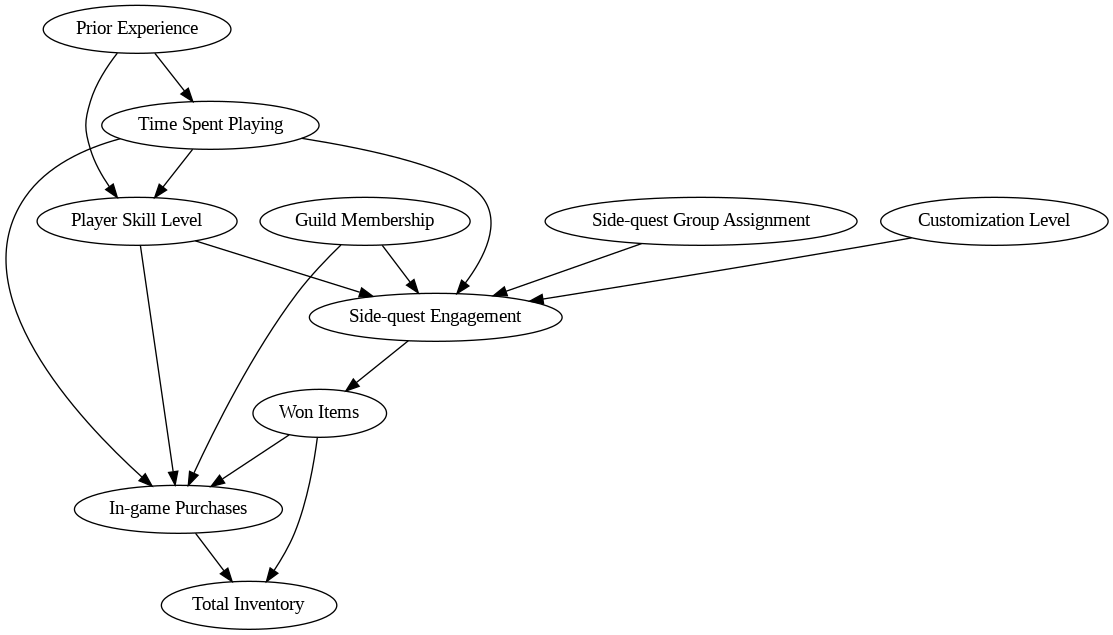

In [2]:
import pygraphviz as pgv    #A
from IPython.display import Image   #B

causal_graph = """
digraph {
    "Prior Experience" -> "Player Skill Level";
    "Prior Experience" -> "Time Spent Playing";
    "Time Spent Playing" -> "Player Skill Level";
    "Guild Membership" -> "Side-quest Engagement";
    "Guild Membership" -> "In-game Purchases";
    "Player Skill Level" -> "Side-quest Engagement";
    "Player Skill Level" -> "In-game Purchases";
    "Time Spent Playing" -> "Side-quest Engagement";
    "Time Spent Playing" -> "In-game Purchases";
    "Side-quest Group Assignment" -> "Side-quest Engagement";
    "Customization Level" -> "Side-quest Engagement";
    "Side-quest Engagement" -> "Won Items";
    "Won Items" -> "In-game Purchases";
    "Won Items" -> "Total Inventory";
    "In-game Purchases" -> "Total Inventory";
}
"""     #C
G = pgv.AGraph(string=causal_graph)    #C
G.draw('/tmp/causal_graph.png', prog='dot')    #D
Image('/tmp/causal_graph.png')    #E

#A Download pygraphviz and related libraries.
#B Optional import for visualizing the DAG in a Jupyter notebook
#C Specify the DAG as a DOT language string and load a pygraphviz AGraph object from the string.
#D Render the graph to a PNG file.
#E Display the graph.

## Listing 11.2: Download and display the data

Let's download our data and see what variables are in our observational distribution.

In [3]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/altdeep/causalML/master/datasets/online_game_example_do_why.csv"    #A
)
print(data.columns)    #B

#A Download an online gaming dataset.
#B Print the variables

Index(['Guild Membership', 'Player Skill Level', 'Time Spent Playing',
       'Side-quest Group Assignment', 'Customization Level',
       'Side-quest Engagement', 'Won Items', 'In-game Purchases',
       'Total Inventory'],
      dtype='object')


## Listing 11.3: Instantiate an instance of DoWhy's CausalModel

In our data, Prior Experience (Y) is unobserved.

![causal DAG with latent](images/gamingDAGLatent.png)

We use the CausalModel class to represent the DAG and tell us if the ATE is identified.

In [4]:
from dowhy import CausalModel    #A

model = CausalModel(
    data=data,    #B
    treatment='Side-quest Engagement',    #C
    outcome='In-game Purchases',    #C
    graph=causal_graph    #D
)

#A Install DoWhy and load the CausalModel class
#B Instantiate the CausalModel object with the data, which represents the level 1 observational distribution from which we derive the estimands.
#C We also specify the target causal query we wish to estimate, namely the causal effect of the "treatment" on the "outcome."
#D And of course we provide the causal DAG.

/usr/local/lib/python3.10/dist-packages/dowhy/causal_model.py:559: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


## Listing 11.4: Run identification in DoWhy

The `identify_effect` methods show us possible estimands we can target given our causal model and observed variables. The `identified_estimand` object is an object of the class `IdentifiedEstimand`. Printing it will list out the estimands, if any, and the assumptions they entail. In our case we have three estimands we can target:
* The backdoor adjustment estimand through the adjustment set Player Skill Level, Guild Membership, and Time Spent Playing
* The front-door adjustment estimand through the mediator Won Items
* Instrumental variable estimands through Side-quest Group Assignment and Customization Level



In [5]:
identified_estimand = model.identify_effect()    #A
print(identified_estimand)

#A The identify_effect method of the CausalModel class lists identified estimands.

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
────────────────────────(E[In-game Purchases|Time Spent Playing,Player Skill L
d[Side-quest Engagement]                                                      

                       
evel,Guild Membership])
                       
Estimand assumption 1, Unconfoundedness: If U→{Side-quest Engagement} and U→In-game Purchases then P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership,U) = P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢                         d                                             ⎛    
E⎢───────────────────────────────────────────────────(In-game Purch

## Listing 11.5 and 11.6. Estimating the backdoor estimand with linear regression (and printing the results)

In DoWhy, we do estimation using a method in the CausalModel class called `estimate_effect`.

In [6]:
causal_estimate_reg = model.estimate_effect(
    identified_estimand,    #A
    method_name="backdoor.linear_regression",    #B
    confidence_intervals=True    #C
)
print(causal_estimate_reg)

#A The estimate_effect method takes an estimand as input.
#B method_name is of the form "[estimand].[estimator]". Here we use linear regression estimator to estimate the backdoor estimand.
#C Return confidence intervals.

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
────────────────────────(E[In-game Purchases|Time Spent Playing,Player Skill L
d[Side-quest Engagement]                                                      

                       
evel,Guild Membership])
                       
Estimand assumption 1, Unconfoundedness: If U→{Side-quest Engagement} and U→In-game Purchases then P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership,U) = P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership)

## Realized estimand
b: In-game Purchases~Side-quest Engagement+Time Spent Playing+Player Skill Level+Guild Membership
Target units: ate

## Estimate
Mean value: 178.0861711575792
95.0% confidence interval: [[168.68114922 187.4911931

The "Causal Estimate" is the estimated coefficient for the treatment variable $v_0$.  The p-value is the significance test statistic for the null hypothesis that the true value of the coefficient is 0.  

Note that once we have established that we want to use regression as the estimation method, all of the model evaluation methods for regression become relevant.  For example, if there were issues with the fit, such as residuals that had unstable variance or correlated with regression variables, it should cause us to question the linear assumption.  We also care about sparsity.  In this case, we had 30 data points to calculate seven coefficient estimates (one for the $v_0$, one each for the common cause confounders $W$'s and an intercept term.  If there were more potential common causes, we might need more data for this method to work.

## Listing 11.7: Propensity Score Stratification

Propensity score methods are a collection of estimation methods for the backdoor estimand that use a quantity called the propensity score. The traditional definition of a propensity score is the probability of being exposed to the treatment conditional on the confounders. In the context of the online gaming example, this is the probability a player has high side-quest engagement given their guild membership (G), time spent playing (T), and player skill level (S), i.e. P(E=1|T=t, G=g, S=s) where t, i, and s are that player’s values for T, I, and S. In other words, it quantifies the player’s “propensity” of being exposed to the treatment (E=1). Typically P(E=1|T=t, G=g, S=s) is fit by logistic regression.
But we can take a more expansive, machine learning friendly view of the propensity score. You can learn a propensity score function λ(...) of the backdoor adjustment set of confounders that renders those confounders conditionally independent of the treatment, as in the following figure.

![DAG with propensity score node](images/propensity_score_node.png)


In [7]:
causal_estimate_strat = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",     #A
    target_units="ate",
    confidence_intervals=True
)

print(causal_estimate_strat)

#A Propensity score stratification

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
────────────────────────(E[In-game Purchases|Time Spent Playing,Player Skill L
d[Side-quest Engagement]                                                      

                       
evel,Guild Membership])
                       
Estimand assumption 1, Unconfoundedness: If U→{Side-quest Engagement} and U→In-game Purchases then P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership,U) = P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership)

## Realized estimand
b: In-game Purchases~Side-quest Engagement+Time Spent Playing+Player Skill Level+Guild Membership
Target units: ate

## Estimate
Mean value: 187.2931023294184
95.0% confidence interval: (180.3291962554186, 196.45

## Listing 11.8: Propensity score matching

Propensity score weighting methods use the propensity score to calculate a weight in a class of inference algorithms called inverse probability weighting. We implement this method in DoWhy as follows.

In [8]:
causal_estimate_match = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",    #A
    target_units="ate",
    confidence_intervals=True
)
print(causal_estimate_match)

#A Propensity score matching

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
────────────────────────(E[In-game Purchases|Time Spent Playing,Player Skill L
d[Side-quest Engagement]                                                      

                       
evel,Guild Membership])
                       
Estimand assumption 1, Unconfoundedness: If U→{Side-quest Engagement} and U→In-game Purchases then P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership,U) = P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership)

## Realized estimand
b: In-game Purchases~Side-quest Engagement+Time Spent Playing+Player Skill Level+Guild Membership
Target units: ate

## Estimate
Mean value: 199.8110290000004
95.0% confidence interval: (183.23361900000054, 210.5

## Listing 11.9: Propensity score weighting
Propensity score weighting methods use the propensity score to calculate a weight in a class of inference algorithms called inverse probability weighting. DoWhy supports [a few different weighting schemes](https://microsoft.github.io/dowhy/dowhy.causal_estimators.html#module-dowhy.causal_estimators.propensity_score_weighting_estimator
):
1. Vanilla Inverse Propensity Score weighting (IPS) (`weighting_scheme="ips_weight"`)
2. Self-normalized IPS weighting (also known as the Hajek estimator) (`weighting_scheme="ips_normalized_weight"`)
3. Stabilized IPS weighting (`weighting_scheme = "ips_stabilized_weight"`)


In [9]:
causal_estimate_ipw = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",    #A
    target_units = "ate",
    method_params={"weighting_scheme":"ips_weight"},    #B
    confidence_intervals=True
)
print(causal_estimate_ipw)

#A Inverse probability weighting
#B Parameters used to set the IPS algorithm.

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
────────────────────────(E[In-game Purchases|Time Spent Playing,Player Skill L
d[Side-quest Engagement]                                                      

                       
evel,Guild Membership])
                       
Estimand assumption 1, Unconfoundedness: If U→{Side-quest Engagement} and U→In-game Purchases then P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership,U) = P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership)

## Realized estimand
b: In-game Purchases~Side-quest Engagement+Time Spent Playing+Player Skill Level+Guild Membership
Target units: ate

## Estimate
Mean value: 437.79246624944926
95.0% confidence interval: (358.10472302821745, 515.

The fact that this estimator’s result differs so dramatically from the others suggest that it is relying on statistical assumptions that don’t hold in this data.

## Listing 11.10: Double ML with DoWhy, EconML, and sklearn

Recent developments in causal effect estimation focus on leveraging machine learning models. Most of these target the backdoor estimand. These approaches to causal effect estimation scale to large datasets and allow us to relax parametric assumptions such as linearity. The following DoWhy code uses the sklearn and EconML libraries for these machine learning methods. DoWhy’s `estimate_effects` provides a wrapper to the EconML’s implementation of these methods.

Double machine learning is a backdoor estimator that uses machine learning methods to fit two predictive models: a model of the outcome given the adjustment set of confounders and a model of the treatment given the adjustment set. The approach then combines these two predictive models in a final-stage estimation to create a model of the target causal effect query.
The following code performs double ML using a gradient boosting model and regularized regression model (LassoCV) from sklearn.


In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

gb_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",    #A
    control_value = 0,
    treatment_value = 1,
    method_params={
        "init_params":{
            'model_y':GradientBoostingRegressor(),    #B
            'model_t': GradientBoostingRegressor(),    #C
            "model_final":LassoCV(fit_intercept=False),    #D
            'featurizer':PolynomialFeatures(degree=1, include_bias=False)
        },
        "fit_params":{}
    }
)
print(gb_estimate)
#A Select the double ML estimator
#B Use a gradient boosting model to model the outcome given the confounders.
#C Use a gradient boosting model to model the treatment given the confounders.
#D Use linear regression with L1 regularization (LASSO) as the final model.

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
────────────────────────(E[In-game Purchases|Time Spent Playing,Player Skill L
d[Side-quest Engagement]                                                      

                       
evel,Guild Membership])
                       
Estimand assumption 1, Unconfoundedness: If U→{Side-quest Engagement} and U→In-game Purchases then P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership,U) = P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership)

## Realized estimand
b: In-game Purchases~Side-quest Engagement+Time Spent Playing+Player Skill Level+Guild Membership | 
Target units: ate

## Estimate
Mean value: 175.7229947190752
Effect estimates: [[175.72299472]]



## Listing 11.11: Backdoor estimation with a meta-learner

Meta learners are another machine learning method for backdoor estimation. Broadly speaking, meta learners train a model (or models) of the outcome given the treatment variable and the confounders, then account for the difference in prediction across treatment and control values of the treatment variable. They are particularly focused on highlighting heterogeneity of treatment effects across the data. The code below shows a meta learner example called a T learner that uses a random forest predictor.


In [11]:
from sklearn.ensemble import RandomForestRegressor    #A
metalearner_estimate = model.estimate_effect(    #A
    identified_estimand,    #A
    method_name="backdoor.econml.metalearners.TLearner",
    method_params={    #A
        "init_params": {'models': RandomForestRegressor()},    #A
        "fit_params": {}    #A
    }    #A
)    #A

print(metalearner_estimate)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                  
────────────────────────(E[In-game Purchases|Time Spent Playing,Player Skill L
d[Side-quest Engagement]                                                      

                       
evel,Guild Membership])
                       
Estimand assumption 1, Unconfoundedness: If U→{Side-quest Engagement} and U→In-game Purchases then P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership,U) = P(In-game Purchases|Side-quest Engagement,Time Spent Playing,Player Skill Level,Guild Membership)

## Realized estimand
b: In-game Purchases~Side-quest Engagement+Time Spent Playing+Player Skill Level+Guild Membership
Target units: ate

## Estimate
Mean value: 197.20665049459512
Effect estimates: [[ 192.6234]
 [  -5.3165]
 [ 133.2

## Listing 11.12: Front-door estimation with DoWhy

Front-door estimation will run a two-stage linear model estimation procedure targeting the front-door estimand.

In [12]:
causal_estimate_fd = model.estimate_effect(
    identified_estimand,
    method_name="frontdoor.two_stage_regression",    #A
    target_units = "ate",
    method_params={"weighting_scheme": "ips_weight"},    #B
    confidence_intervals=True
)
print(causal_estimate_fd)

#A Select two stage regression for the front door estimand.
#B Specify estimator hyperparameters.

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: frontdoor
Estimand expression:
 ⎡     d                                     d                         ⎤
E⎢────────────(In-game Purchases)⋅────────────────────────([Won Items])⎥
 ⎣d[Won Items]                    d[Side-quest Engagement]             ⎦
Estimand assumption 1, Full-mediation: Won Items intercepts (blocks) all directed paths from Side-quest Engagement to I,n,-,g,a,m,e, ,P,u,r,c,h,a,s,e,s.
Estimand assumption 2, First-stage-unconfoundedness: If U→{Side-quest Engagement} and U→{Won Items} then P(Won Items|Side-quest Engagement,U) = P(Won Items|Side-quest Engagement)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Won Items} and U→In-game Purchases then P(In-game Purchases|Won Items, Side-quest Engagement, U) = P(In-game Purchases|Won Items, Side-quest Engagement)

## Realized estimand
(b: Won Items~Side-quest Engagement)*(b: In-game Purchas

## 11.13: Instrumental variable estimation and regression discontinuity

Instrumental variable (IV) estimation uses the instrument Side-quest Group Assignment to estimate an estimand that doesn't depend on any of the common causes in the estimation.  Whether or not IV estimation is possible depends on the causal DAG.  Like regression estimation, it relies on certain parametric assumptions as well.

In [13]:
causal_estimate_iv = model.estimate_effect(
    identified_estimand,
    method_name="iv.instrumental_variable",    #A
    method_params = {
        "iv_instrument_name": "Side-quest Group Assignment"    #B
    },
    confidence_intervals=True
)
print(causal_estimate_iv)

#A Select intrumental variable estimation.
#B Select side-quest engagement as the instrument.

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢                         d                                             ⎛    
E⎢───────────────────────────────────────────────────(In-game Purchases)⋅⎜────
 ⎣d[Side-quest Group Assignment  Customization Level]                    ⎝d[Si

                                                                         -1⎤
                     d                                                  ⎞  ⎥
───────────────────────────────────────────────([Side-quest Engagement])⎟  ⎥
de-quest Group Assignment  Customization Level]                         ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→In-game Purchases then ¬(U →→{Side-quest Group Assignment,Customization Level})
Estimand assumption 2, Exclusion: If we remove {Side-quest Group Assignment,Customization Level}→{Sid

The large confidence interval suggests this estimator has too much variance to be useful.

## Listing 11.14 Regression discontinuity estimation with DoWhy

Regression discontinuity is an estimation method popular in econometrics.  Regression discontinuity tries to model the "do" intervention by finding a threshold on a continuous variable that partitions the data into two parts corresponding to two different "do" values (e.g., "treatment" and "control").  It compares observations lying closely on either side of the threshold because data points close to that threshold will have similar values for the confounders.

DoWhy treats it as a special type of [IV approach](https://microsoft.github.io/dowhy/dowhy.causal_estimators.html#dowhy.causal_estimators.regression_discontinuity_estimator.RegressionDiscontinuityEstimator
). The argument `rd_variable_name` name of the variable on where the thresholding occurs. This variable is analogous to the instrument.
`rd_threshold_value` is the threshold value where the split (or "discontinuity") occurs.  `rd_bandwidth` is the distance from the threshold within which confounders can be considered the same between treatment and control.
*italicized text*


In [14]:
%%capture
causal_estimate_regdist = model.estimate_effect(
    identified_estimand,
    method_name="iv.regression_discontinuity",    #A
    method_params={
        'rd_variable_name':'Customization Level',    #B
        'rd_threshold_value':0.5,    #C
        'rd_bandwidth': 0.15    #D
    },
    confidence_intervals=True,
)

#A DoWhy treats it as a special type of IV estimator.
#B Using Customization Level as our instrument.
#C The threshold value for the split ("discontinuity").
#D The distance from the threshold within which confounders are considered the same between treatment and control values of the treatment variable.

In [15]:
print(causal_estimate_regdist)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢                         d                                             ⎛    
E⎢───────────────────────────────────────────────────(In-game Purchases)⋅⎜────
 ⎣d[Side-quest Group Assignment  Customization Level]                    ⎝d[Si

                                                                         -1⎤
                     d                                                  ⎞  ⎥
───────────────────────────────────────────────([Side-quest Engagement])⎟  ⎥
de-quest Group Assignment  Customization Level]                         ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→In-game Purchases then ¬(U →→{Side-quest Group Assignment,Customization Level})
Estimand assumption 2, Exclusion: If we remove {Side-quest Group Assignment,Customization Level}→{Sid

Again, though the estimate is not too far off the those of the other estimators, the confidence intervals are a bit too large for comfort, suggesting either the instrument is weak or that we need to tune the arguments passed to the estimator.


## Listing 11.15: Refutating the assumption of sufficient data

Refutation sensitivity tests enable us to test the sensitivity of our estimations to violations of our model assumptions.

### Data size reduction
One way to test the robustness of the analysis is to reduce the size of the data and see if you obtain similar results.  If the size of your data small relative to your estimator, then removal of that already sparse data would have an impact on your results.

In [16]:
identified_estimand.set_identifier_method("frontdoor")    #A
res_subset = model.refute_estimate(
    identified_estimand,    #B
    causal_estimate_fd,    #C
    method_name="data_subset_refuter",    #D
    subset_fraction=0.8,    #E
    num_simulations=100    #F
)
print(res_subset)

#A Not strictly necessary, but in some cases clarifying the estimand when working with refuters helps avoid errors.
#B The refute_estimate function takes in the identified estimand...
#C ... and the estimator that targets the estimand.
#D We select "data_subset_refuter", which tests if the causal estimate is different when we run the analysis on a subset of the data.
#E Set the size of the subset to 80% the size of the original data.
#F Set the number of simulations to 30.

Refute: Use a subset of data
Estimated effect:170.20560581290403
New effect:170.58032441316368
p value:0.94



“Estimand Effect” is the effect from our original analysis.  “New effect” is the average ATE across the simulations.  We hope these two effects to be similar.  The p-value is calculated under the null hypothesis that the two are the same.  P-values falling below a traditional significance threshold (e.g., .1, .05) indicate evidence that the two effects are different, which would mean our analysis is sensitive to the size of our data.  This is not the case with our analysis, since our p-value is high.

## Listing 11.16: Adding a dummy variable

One way to test our models is to add dummy variables – variables that have no causal bearing on our problem, but where the additional noise can impact the performance of the statistical estimator.  One way to test this is by adding a dummy confounder and re-running the analysis.  The dummy confounder is a random variable that is not actually a confounder, it is completely independent of the treatment and outcome variables, but the analysis treats it as a confounder.  By doing this many times, we can evaluate how sensitive your results are to the random common cause.

In [17]:
identified_estimand.set_identifier_method("backdoor")

res_random = model.refute_estimate(    #A
    identified_estimand,    #A
    gb_estimate,    #A
    method_name="random_common_cause",    #A
    num_simulations=100,    #A
    n_jobs=2    #A
)    #A
print(res_random)


Refute: Add a random common cause
Estimated effect:175.7229947190752
New effect:176.48265445185297
p value:0.6200000000000001



“Estimated effect” is the original causal effect estimate that we obtained from your model before running the refutation test.  “New effect” is the new causal effect estimate obtained after adding a random common cause to your data and re-running the analysis.  “p value” is the p-value of the test comparing the original and new estimated effects. A small p-value suggests that the two effects are statistically different, indicating that your original estimate might be sensitive to potential unobserved confounding.
Given ourresults, the original estimated effect and the new effect after adding a random common cause are quite similar, and the p-value is greater than typical significance cutoffs (e.g., 0. or 0.05). This means there's no strong statistical evidence to suggest that the estimated effect changes significantly with the addition of a random common cause. So, the original estimated causal effect appears to be quite robust, at least to the addition of random common causes, according to this specific refutation test.

## Listing 11:17: Replacing the treatment variable with a dummy variable

We can also experiment with replacing the treatment variable with a dummy (placebo) variable.  Here, we expect the ATE to be close to 0.

In [18]:
identified_estimand.set_identifier_method("backdoor")

res_placebo = model.refute_estimate(
    identified_estimand,    #A
    causal_estimate_ipw,    #A
    method_name="placebo_treatment_refuter",    #A
    placebo_type="permute",    #A
    num_simulations=100    #A,
)

print(res_placebo)

#A This refuter replaces the treatment variable with a dummy (placebo) variable.

Refute: Use a Placebo Treatment
Estimated effect:437.79246624944926
New effect:-537.0954621014946
p value:0.0



“New Effect” is the ATE generated when the treatment variable (in our case Tech Support) is replaced in the analysis by a random dummy variable.  We expect the new ATE to be 0, and the p-value here compares New Effect value to 0.  Values that are significantly different from 0 will have a low p-value.  When the p-value falls below typical significance thresholds (e.g., .05), the test shows evidence that your analysis might be overly sensitive and that you should be suspicious of your ATE estimates.  In our case, the high p-value suggests that this is not the case.


## Listing 11.18: Replacing the outcome variable with a dummy variable

We can substitute the outcome variable with a dummy variable. The ATE in this case should be 0 because the treatment has no effect on this dummy. We’ll simulate it as a linear function of some of the confounders so the outcome still has a meaningful relationship with some of the covariates. I’ll try this with the front door estimator.

In [19]:
import numpy as np

coefficients = np.array([100.0, 50.0])
bias = 50.0
def linear_gen(df):     #A
    subset = df[['guild_membership','player_skill_level']]     #A
    y_new = np.dot(subset.values, coefficients) + bias     #A
    return y_new     #A

identified_estimand.set_identifier_method("frontdoor")
ref = model.refute_estimate(    #B
    identified_estimand,    #B
    causal_estimate_fd,    #B
    method_name="dummy_outcome_refuter",    #B
    outcome_function=linear_gen    #B
)    #B

res_dummy_outcome = ref[0]
print(res_dummy_outcome)

#A Create a function that generates a new dummy outcome variable as a linear function of the covariates.
#B Runs refute_estimate with a dummy outcome refuter.


Refute: Use a Dummy Outcome
Estimated effect:0
New effect:170.20560581290403
p value:0.0



Again, the p-value is calculated under the null hypothesis that New effect equals 0, and a low p-value refutes our assumptions. In this case, our assumptions are not refuted.


## Listing 11.19: Adding an unobserved confounder

Since we used backdoor adjustment, we assume that the adjustment set blocks all backdoor paths.  If there were an unobserved confounder that we failed to adjust for, that assumption is violated and our estimate would have confounder bias.  That is not necessarily the worst thing; if we adjust for all major confounders, any bias from unobserved confounders could be small and not impact our results by much.  On the other hand, missing a major confounder could lead us to conclude there is a nonzero ATE when there is none, or conclude a positive ATE when the true ATE is negative, or vice versa.  We therefore test our robust our analysis is to introducing unobserved confounders.

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


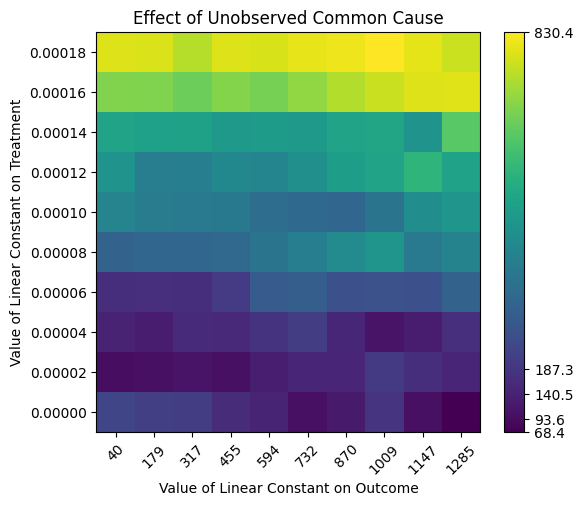

Refute: Add an Unobserved Common Cause
Estimated effect:187.2931023294184
New effect:(68.41879226377264, 830.392600729665)



In [20]:
identified_estimand.set_identifier_method("backdoor")
res_unobserved = model.refute_estimate(    #A
    identified_estimand,    #A
    causal_estimate_strat,    #A
    method_name="add_unobserved_common_cause"    #A
)    #A

print(res_unobserved)

#A Setting up a refuter that adds an unobserved common cause

This analysis does not return a p-value. It produces the above heat map, which shows how quickly the estimate changes when the no unobserved confounder assumption is violated.  The horizontal axis in the heat map shows the various levels of influence the unobserved confounder has on the outcome, and the vertical axis shows the various levels of influence the confounder can have on the treatment. The color corresponds to the new effect estimates that result at different levels of influence. Here, we see the ATE is quite sensitive to the effect the confounder has on the treatment. Note that you can change the default parameters of the refuter to experiment with different impacts the confounder could have on the treatment and outcome.